In [1]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_swissre = pd.read_csv('./data/economic_weighted.csv', parse_dates=['date']).set_index('date')

iso_codes = ['AUT','BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR', 'CHE', 'NOR']

data_swissre = data_swissre[data_swissre['iso_code'].isin(iso_codes)]

/Users/giorgiomannarini/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Selecting columns for the first model

In [3]:
with open('config/economic_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic'] +\
            swissre_features['vaccines'] +\
            swissre_features['policies']+\
            swissre_features['outcome']

rep_rate = 'epiforecasts_effective_reproduction_number_median'

In [5]:
df = data_swissre[columns_to_use].copy()
df.columns

Index(['name', 'iso_code', 'cases', 'weight',
       'epiforecasts_effective_reproduction_number_median',
       'total_population_all', 'total_population_below_1',
       'total_population_1_to_4', 'total_population_5_to_14',
       'total_population_15_to_24', 'total_population_25_to_34',
       'total_population_35_to_54', 'total_population_55_to_74',
       'total_population_above_75', 'population_percentage_over_60',
       'hospital_beds_per_1000', 'physicians_per_1000', 'nurses_per_1000',
       'maxtempC', 'mintempC', 'tempC', 'FeelsLikeC', 'humidity', 'pressure',
       'HeatIndexC', 'uvIndex', 'totalSnow_cm', 'sunHour', 'windspeedKmph',
       'precipMM', 'unemployment_rate_2021_09_30',
       'unemployment_rate_2021_12_31', 'unemployment_rate_2019_03_31',
       'unemployment_rate_2019_06_30', 'unemployment_rate_2019_09_30',
       'unemployment_rate_2019_12_31', 'gdp_2019_03_31', 'gdp_2019_06_30',
       'gdp_2019_09_30', 'gdp_2019_12_31', 'gdp_2020_03_31', 'gdp_2020_06_30'

In [6]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index() #

In [7]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [8]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


In [9]:
# Putting NaN where the estimated reproduction number is larger than 4
df[rep_rate] = np.where(df[rep_rate] >= 4, np.nan, df[rep_rate])

In [10]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])
df['shifted_r_estim'] = df[rep_rate]

In [11]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


# Training the first model

In [12]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot

In [14]:
final_iso_code = 'FRA'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['vaccines']+\
            swissre_features['economic'] +\
            swissre_features['policies']+ ['shifted_r_estim'] +\
            swissre_features['weather']

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
final_train_cols = [col for col in final_train_cols if not df[df['iso_code'] != final_iso_code][col].std() == 0]

In [15]:
list(set(train_cols) - set(final_train_cols))

['Pfizer/BioNTech', 'Sinovac', 'EpiVacCorona', 'Sinopharm/Wuhan', 'Covaxin']

In [16]:
context = Context()

Global seed set to 42


In [17]:
pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', final_iso_code, 28, context, 'weight') #shifted_r_estim
pipeline.fit_pipeline(save_model=False)

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 4.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
7.3 K     Trainable params
0         Non-trainable params
7.3 K     Total params
0.029     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

............................................

In [18]:
predictions = pipeline.predict()

plot = Plot(df, 'unemployment_rate_idx', final_iso_code, save_path='./plots/')

The mean average error was 0.8754586187478146


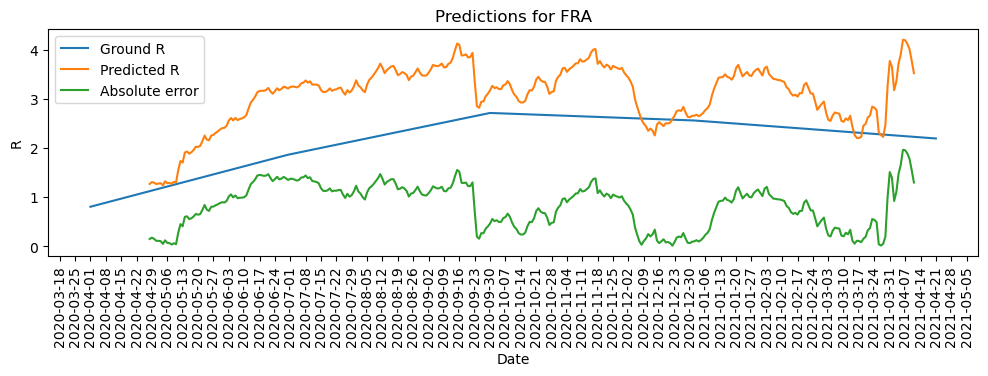

In [19]:
plot.plot_results(predictions, show = True)

<AxesSubplot:xlabel='index'>

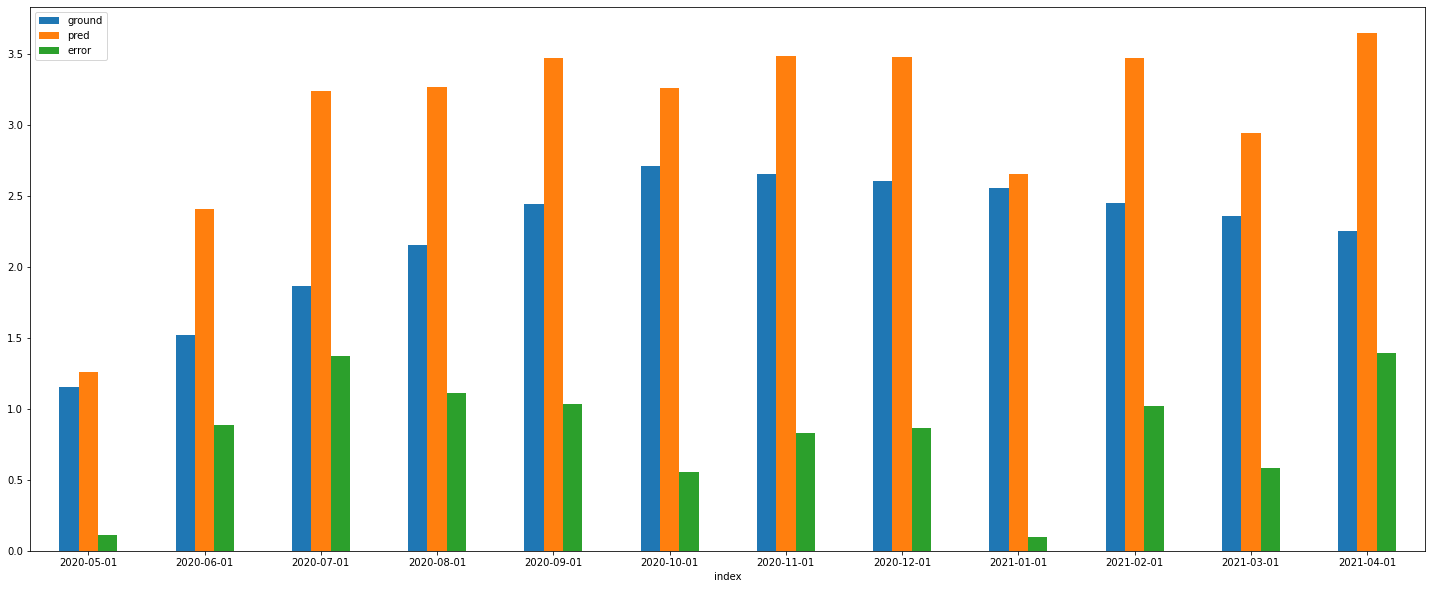

In [20]:
test_indices = df['iso_code'] == final_iso_code
index = df.loc[test_indices].index
ground = df.loc[test_indices]['unemployment_rate_idx']
error_curve = np.abs(ground - predictions)

df2 = pd.DataFrame({'index': index, 'ground': ground, 'pred': predictions, 'error': error_curve}).sort_values(by = 'index')
df2 = df2[(df2['index'] >= '2020-05-01') & (df2['index'].dt.day == 1)]

df2['index'] = df2['index'].dt.date


df2.plot.bar(x = 'index', y = ['ground', 'pred', 'error'], rot = 0, figsize=(25, 10))

## Predictions for each country

In [19]:
index = []
ground = []
error_curve = []
country = []
predictions_list = []

for final_iso_code in iso_codes:
    # Final training colums
    train_cols= swissre_features['demography'] +\
                swissre_features['sanitary'] +\
                swissre_features['vaccines']['to_use'] +\
                swissre_features['economic']['to_use'] +\
                swissre_features['policies']['to_use'] + ['shifted_r_estim'] #swissre_features['weather'] +\

    final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
    final_train_cols = [col for col in final_train_cols if not df[col].std() == 0]
    context = Context()
    pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', final_iso_code, 28, context, 'weight') #shifted_r_estim
    try:
        pipeline.fit_pipeline(save_model=False)
        predictions = pipeline.predict()
        test_indices = df['iso_code'] == final_iso_code
        index_iso = df.loc[test_indices].index
        ground_iso = df.loc[test_indices]['unemployment_rate_idx']
        error_curve_iso = np.abs(ground_iso - predictions)
        country_iso = [final_iso_code for i in index_iso]
        index.extend(index_iso)
        ground.extend(ground_iso)
        error_curve.extend(error_curve_iso)
        country.extend(country_iso)
        predictions_list.extend(predictions)
    except:
        print(f"NOT ENOUGH DATA FOR COUNTRY {final_iso_code}")
    

result_df = pd.DataFrame({'iso_code': country, 'index': index, 'ground': ground, 'pred': predictions_list, 'error': error_curve}).sort_values(by = 'index')
result_df = result_df[(result_df['index'] >= '2020-05-01') & (result_df['index'].dt.day == 1)]
result_df['index'] = result_df['index'].dt.date
result_df

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.8 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...............................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


................................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


...........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
Global seed set to 42
Global seed set to 42


NOT ENOUGH DATA FOR COUNTRY MLT
Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.....................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..................................................................................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


.............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


..........................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


......................................................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

Global seed set to 42
Global seed set to 42


.Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 3.4 K 
1 | linear_1 | Linear | 1.9 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


............................

,iso_code,index,ground,pred,error
4662,GBR,2020-05-01,1.797143,1.182496,0.614646
3118,ESP,2020-05-01,5.930440,1.829132,4.101308
10066,SVK,2020-05-01,1.760549,5.946790,4.186241
30,AUT,2020-05-01,0.835934,1.512610,0.676676
6592,ITA,2020-05-01,0.906044,3.518695,2.612651
...,...,...,...,...,...
1523,CHE,2021-04-01,1.798352,1.803374,0.005022
365,AUT,2021-04-01,1.737912,1.258592,0.479320
2681,DEU,2021-04-01,1.288791,2.082680,0.793889
6155,HUN,2021-04-01,1.744286,0.000000,1.744286


In [31]:
result_df.rename(columns={"index": "date"}).to_csv("./data/Economic_data/economic_predictions.csv", index=False)